In [1]:
import numpy as np
import matplotlib.pyplot as plt
from my_functions import *

In [2]:
## Load the catalog
cat = load_cat_photoz_gaia('csv/minijpas.flambda_photoz_gaia.csv')

In [3]:
tcurves = load_tcurves(load_filter_tags())

In [4]:
# Define the array of the filters we are going to use // gSDSS band
nb_ind_arr = [8, 9, 10, 11, 12, 13, 14, 15]
bb_ind = -3

In [5]:
# Function to drop sources
def make_masks(cat, nb_ind):
    # Mask sources with high photoz odds
    mask_pz_odds = cat['odds'] < 0.98
    # Mask sources with proper motion according to Gaia (sigma > 3)
    parallax_sn = np.abs(cat['parallax'] / cat['parallax_err'])
    pmra_sn = np.abs(cat['pmra'] / cat['pmra_err'])
    pmdec_sn = np.abs(cat['pmdec'] / cat['pmdec_err'])
    mask_pmotion = (
        (np.sqrt(parallax_sn**2 + pmra_sn**2 + pmdec_sn**2) < 27.**0.5)
        | ( np.isnan(parallax_sn) | np.isnan(pmra_sn) | np.isnan(pmdec_sn) )
    )
    # Mask sources with SNR < 5 in the selected NB
    mask_snr = cat['flx_err'][:,nb_ind] < 0.2
    
    mask_total = mask_pz_odds & mask_pmotion & mask_snr
    return mask_total

In [14]:
nb_ind = 25
mask = make_masks(cat, nb_ind)
pm_flx = cat['flx'][mask] * 1e-19
pm_err = cat['flx_err'][mask] * pm_flx
fwhm_nb = nb_fwhm(tcurves, nb_ind, True)
w_central = np.array(central_wavelength(load_tcurves(load_filter_tags())))
N_nb = 10 # Number of nb on each side of the central one
line, cf, cont_err = nbex_cont_estimate(pm_flx, pm_err, nb_ind, w_central, N_nb, 50, fwhm_nb)

In [15]:
len(np.where(line)[0])

16

In [16]:
bb_fwhm = [
    nb_fwhm(tcurves, -4, True),
    nb_fwhm(tcurves, -3, True),
    nb_fwhm(tcurves, -2, True),
    nb_fwhm(tcurves, -1, True)
]

240600768


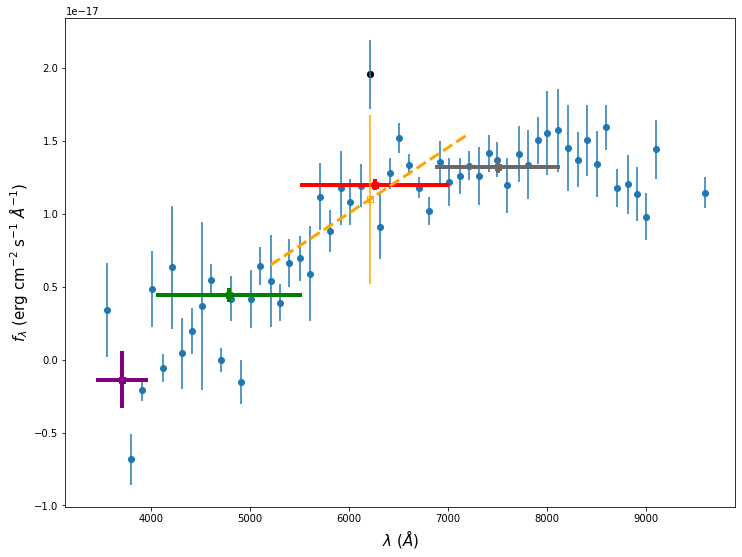

240601311


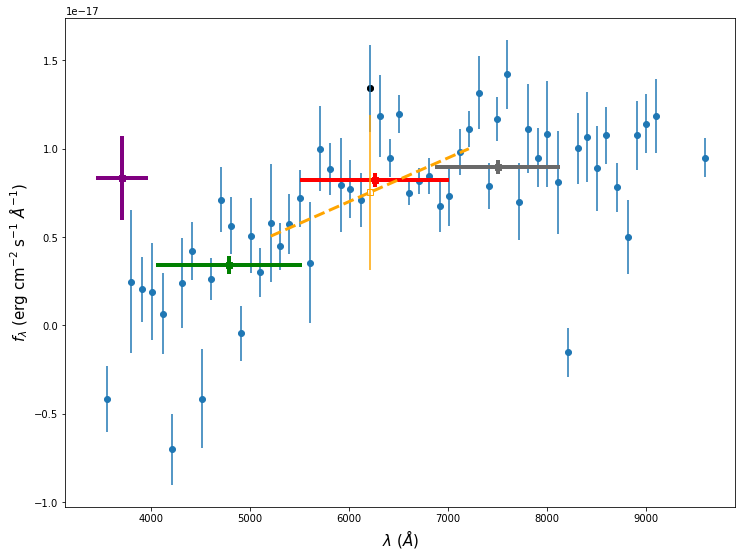

240602337


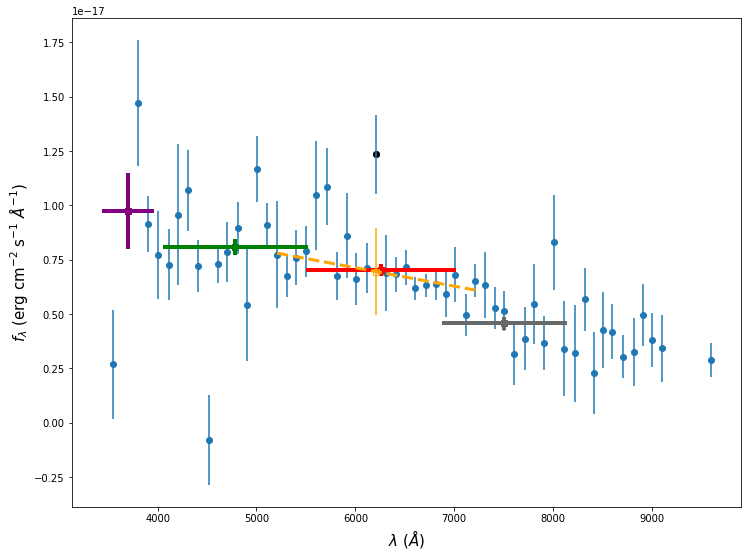

240603305


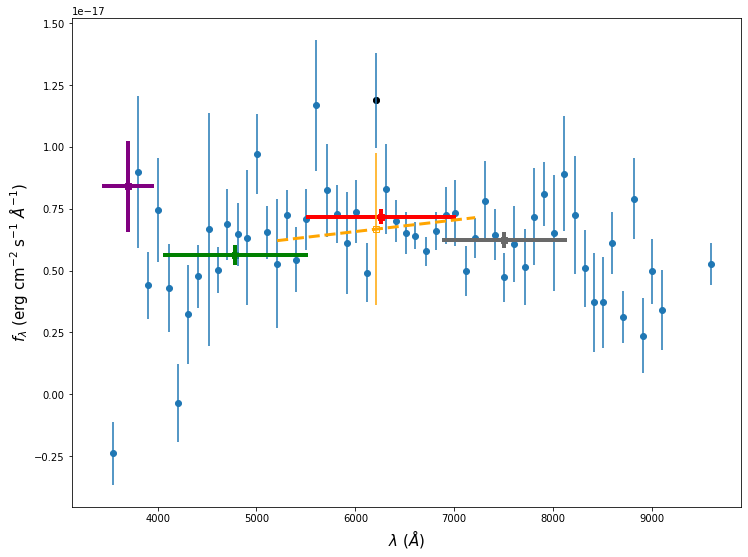

224104880


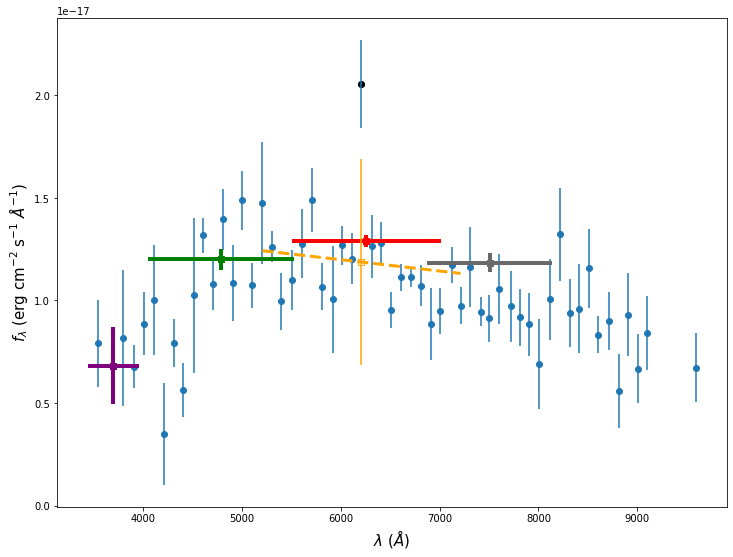

240609420


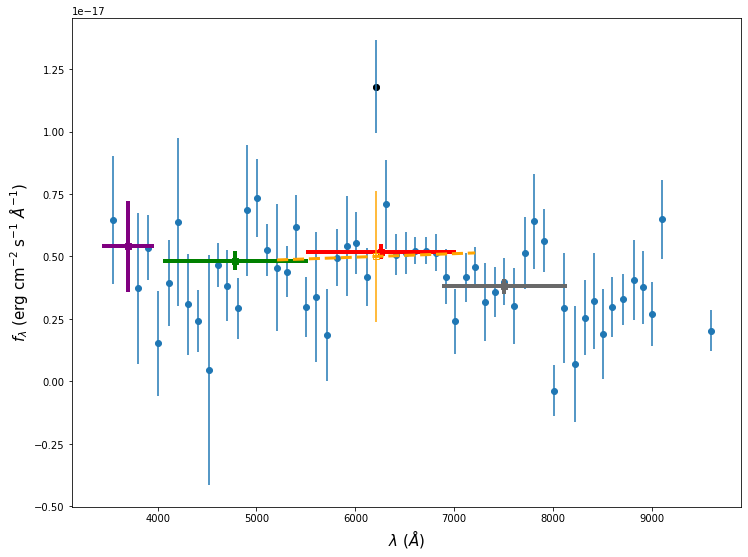

224108803


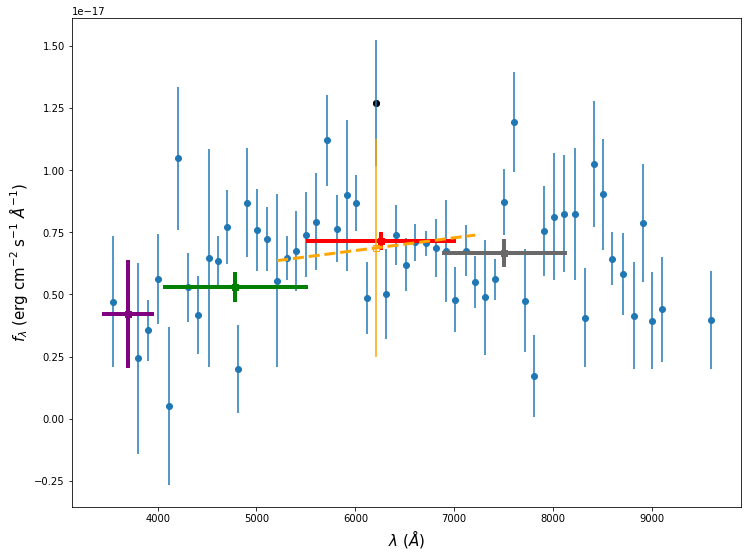

240614898


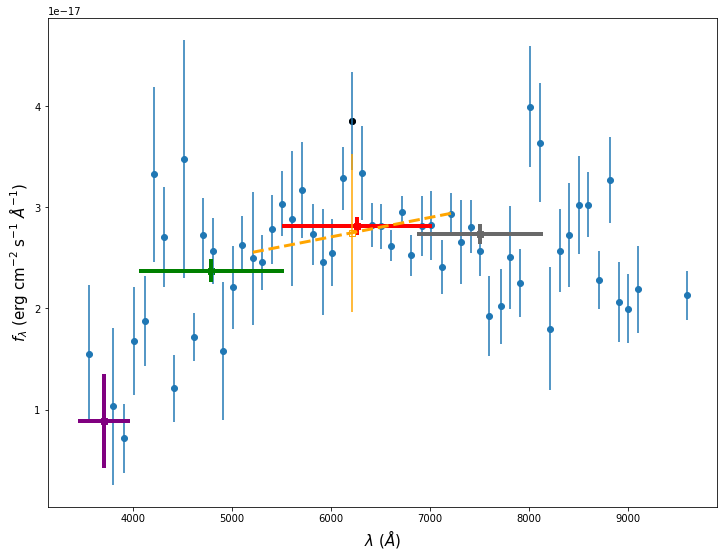

224113973


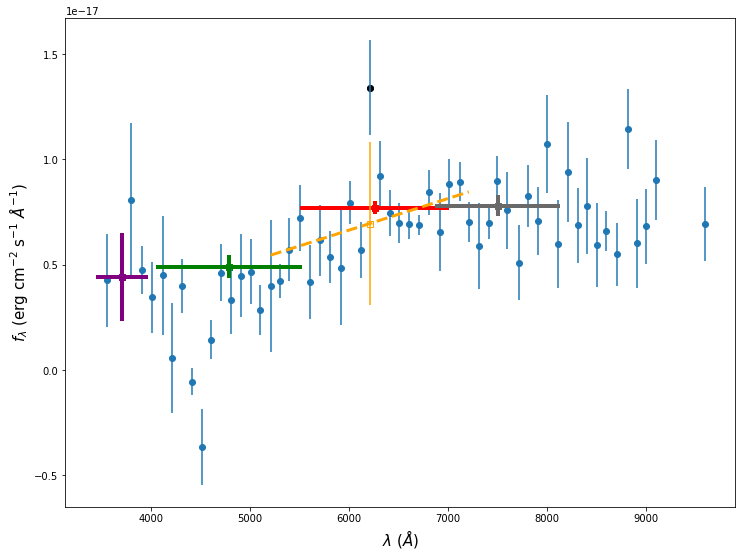

224115536


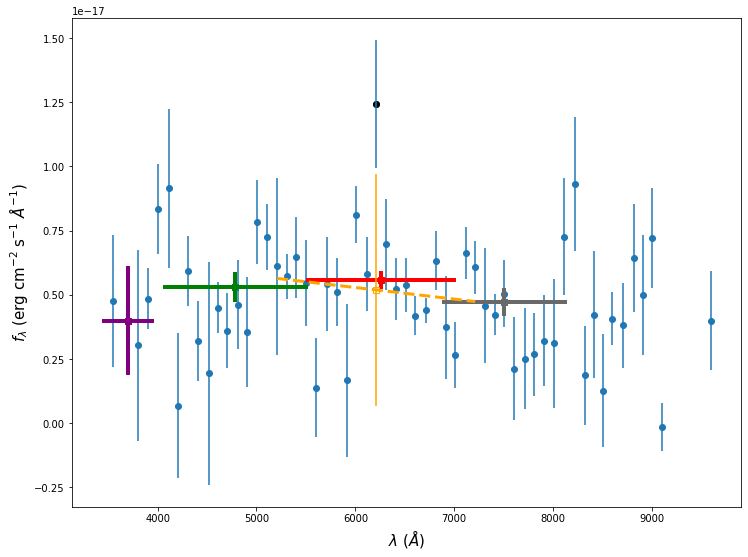

224115644


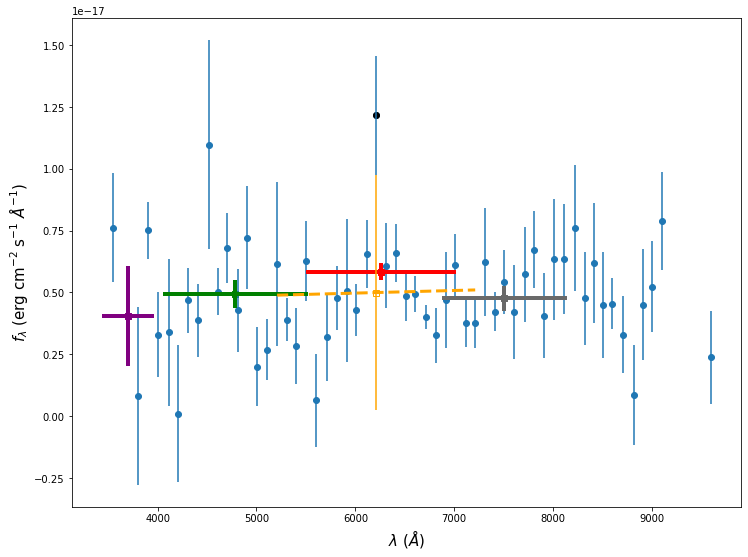

224118494


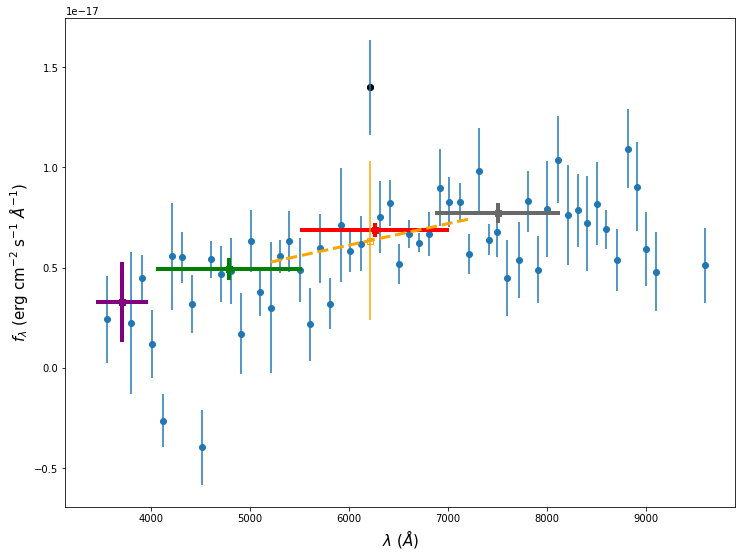

224119525


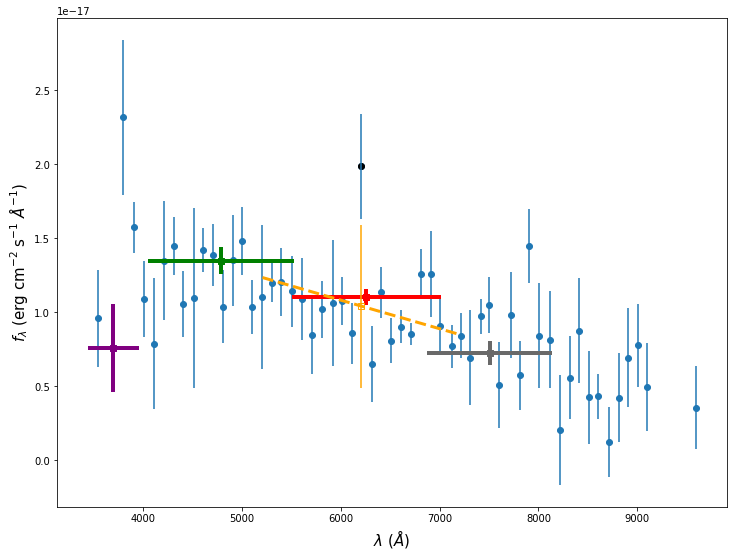

224302957


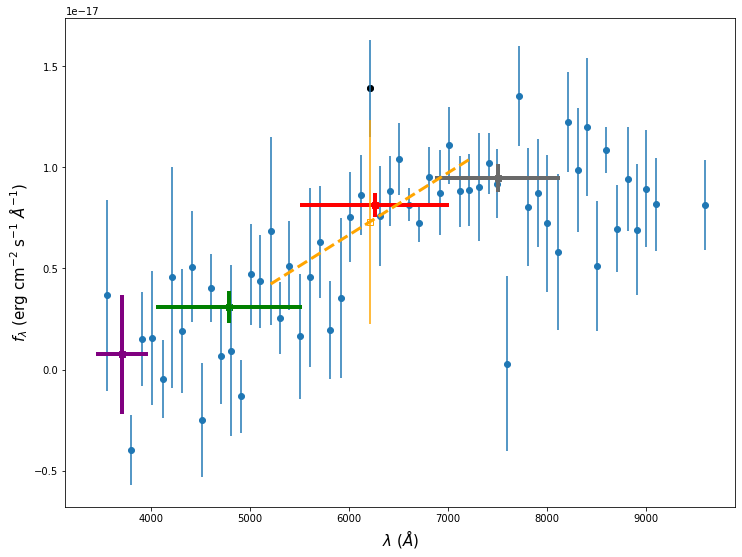

224304646


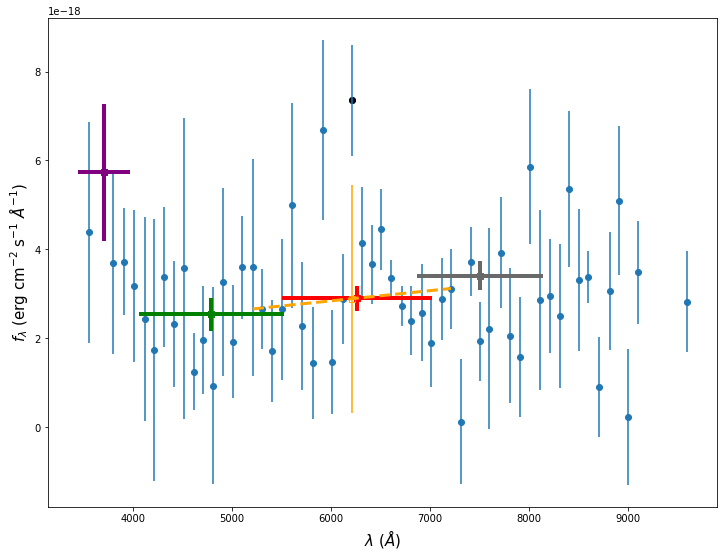

224313612


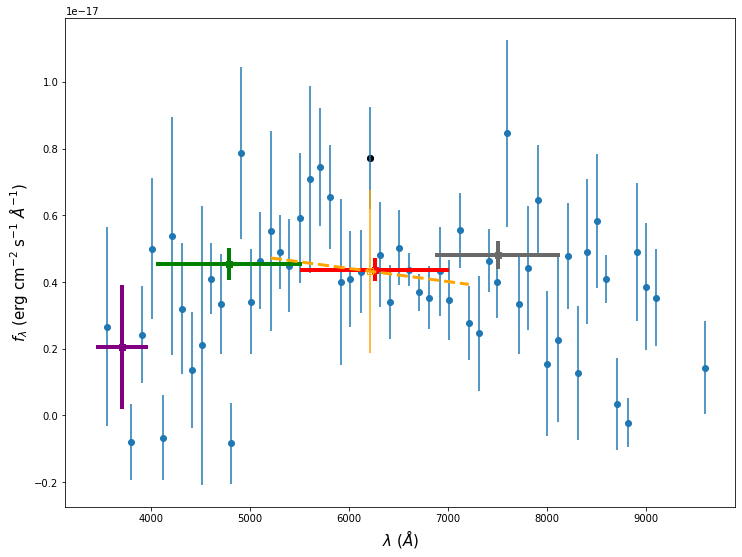

In [17]:
for i in range(len(line)):
    if ~line[i]: continue
        
    pm = pm_flx[i]
    errors = pm_err[i]
    cont_fit = cf[i]
    fit_err = cont_err[i]
    
    fig, ax = plt.subplots(figsize=(12,9))
    ax.scatter(w_central[:-3], pm[:-3])
    ax.errorbar(w_central[:-3], pm[:-3], yerr=errors[:-3], fmt='none')
    ax.scatter(w_central[nb_ind], pm[nb_ind], c='black')

    ax.scatter(w_central[-4], pm[-4], c='purple' , marker='s')
    ax.scatter(w_central[-3], pm[-3], c='green'  , marker='s')
    ax.scatter(w_central[-2], pm[-2], c='red'    , marker='s')
    ax.scatter(w_central[-1], pm[-1], c='dimgray', marker='s')

    ax.errorbar(w_central[-4], pm[-4], xerr=bb_fwhm[-4]/2, yerr = errors[-4],
                fmt='none', color='purple', elinewidth=4)
    ax.errorbar(w_central[-3], pm[-3], xerr=bb_fwhm[-3]/2, yerr = errors[-3],
                fmt='none', color='green', elinewidth=4)
    ax.errorbar(w_central[-2], pm[-2], xerr=bb_fwhm[-2]/2, yerr = errors[-2],
                fmt='none', color='red', elinewidth=4)
    ax.errorbar(w_central[-1], pm[-1], xerr=bb_fwhm[-1]/2, yerr = errors[-1],
                fmt='none', color='dimgray', elinewidth=4)

    ax.set_xlabel('$\lambda\ (\AA)$', size=15)
    ax.set_ylabel('$f_\lambda$ (erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)', size=15)

    # Fit line
    w_fit_min = w_central[nb_ind - N_nb]
    w_fit_max = w_central[nb_ind + N_nb]
    x_fit = np.linspace(w_fit_min, w_fit_max, 1000)
    y_fit = cont_fit[1] + cont_fit[0]*x_fit
    ax.plot(x_fit,y_fit, c='orange', linestyle='dashed', linewidth=3)
    ax.errorbar(w_central[nb_ind], cont_fit[1] + cont_fit[0]*w_central[nb_ind],
               yerr=fit_err, c='orange', marker='s', markerfacecolor='none')
    
    print(cat['number'][mask][i])
    
    plt.show()